<a target="_blank" href="https://colab.research.google.com/github/umanitoba-meagher-projects/public-experiments/blob/main/jupyter-notebooks/Explore%20Large%20Image%20Datasets/random-manual-review.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
"""
Author: Ryleigh J. Bruce
Date: June 7, 2024

Purpose: Copy a subset of images to a new folder for manual review.


Note: The author generated this text in part with GPT-4,
OpenAI’s large-scale language-generation model. Upon generating
draft code, the authors reviewed, edited, and revised the code
to their own liking and takes ultimate responsibility for
the content of this code.

"""

# Overview

This notebook provides a workflow for selecting a random subset of images from a larger dataset for manual review. The goal in doing this is to facilitate the process of sampling, organizing, and visually inspecting images.

# Critical Uses & Adaptability

## What the Notebook Can Be Used For:

- Randomly sample and inspect images from large datasets.

- Automate repetitive tasks and learn foundational concepts in working with image data.

- Extend the workflow to include feature extraction or pre-processing steps. This can include extracting metadata, computing image statistics, or preparing data for downstream analysis.

## How the Notebook Can Be Adapted:

- The animal image dataset can be substituted with collections relevant to architectural contexts such as site photographs, plan scans, or spatial diagrams. The random sampling and visualization steps support unbiased review and documentation of spatial features.

- Variables such as `source_dir`, `destination_dir`, `number_of_images`, and `images_to_display` can be modified to adjust the source and target locations, the number of images sampled, and the number of images displayed, tailoring the workflow to specific project requirements.

- To use a different image dataset, change the `source_dir` and `destination_dir` variables in the cell labeled "Step 2: Set your paths and parameters."

### Access the Borealist Dataset and Install Necessary Libraries

This module sets up the base server URL for the Borealis data repository and imports libraries for HTTP requests and ZIP file handling. Borealis data access functions are defined, allowing the notebook to download and access files from the Borealis public data repository with the use of file IDs and without requiring authentication.

This snippet of code finds specific files within the dataset and automatically handle ZIP extraction.

Key features include; error handling for failed requests and invalid files, streaming downloads to handle large files efficiently, and automatic filename detection from HTTP headers or ZIP extraction with folder structure preservation



The data is hosted in the University of Manitoba Dataverse (https://borealisdata.ca/dataverse/manitoba), a research data repository. The images used in this notebook were collected as part of the 'Understanding Animals' project at University of Manitoba Faculty of Architecture, online at [Wild Winnipeg](https://www.wildwinnipeg.org/) and [Teaching with Images](https://pressbooks.openedmb.ca/teachingwithimages/).

In [3]:
# Borealis API configuration
import requests
import zipfile

BOREALIS_SERVER = "https://borealisdata.ca"

def get_public_dataset_info(persistent_id):
    """
    Get information about a public dataset
    """
    url = f"{BOREALIS_SERVER}/api/datasets/:persistentId/"
    params = {"persistentId": persistent_id}

    response = requests.get(url, params=params)

    if response.status_code == 200:
        dataset_info = response.json()
    else:
        print(f"Cannot access dataset: {response.status_code}")
        return None
    """
    Get a list of files in a public dataset
    """
    # Access the list of files from the dataset_info dictionary
    files_list = dataset_info['data']['latestVersion']['files']

    # Create an empty list to store file information
    file_info_list = []

    # Iterate through the files list and append file ID and filename to the list
    for file_info in files_list:
        file_id = file_info['dataFile']['id']
        filename = file_info['dataFile']['filename']
        file_info_list.append({"file_id": file_id, "filename": filename})

    return file_info_list

def download_public_file(file_id, save_path="./"):
    """
    Download a specific public file from a dataset by its file ID
    No authentication required
    """
    url = f"{BOREALIS_SERVER}/api/access/datafile/{file_id}"

    response = requests.get(url, stream=True)

    if response.status_code == 200:
        # Determine filename from headers or URL
        filename = None
        if "Content-Disposition" in response.headers:
            cd = response.headers["Content-Disposition"]
            # Try to extract filename from content disposition
            if "filename=" in cd:
                filename = cd.split("filename=")[1].strip('"')

        # Fallback to extracting from URL if header not available or malformed
        if not filename:
             filename = url.split("/")[-1]

        file_path = f"{save_path}/{filename}"

        with open(file_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"SUCCESS: File downloaded to {file_path}")
        return file_path
    else:
        print(f"ERROR: {response.status_code}: File may be restricted or not found")
        return None

def is_zip_file(filepath):
    """
    Checks if a file is a valid zip file.
    """
    return zipfile.is_zipfile(filepath)

def unzip_file(filepath, extract_path="./"):
    """
    Unzips a zip file to a specified path and returns the name of the top-level extracted folder.
    Returns None if not a zip file or extraction fails.
    """
    if is_zip_file(filepath):
        try:
            with zipfile.ZipFile(filepath, 'r') as zip_ref:
                # Get the name of the top-level directory within the zip
                # Assumes there is a single top-level directory
                top_level_folder = None
                for file_info in zip_ref.infolist():
                    parts = file_info.filename.split('/')
                    if parts[0] and len(parts) > 1:
                        top_level_folder = parts[0]
                        break # Assuming the first entry gives the top-level folder

                zip_ref.extractall(extract_path)
                print(f"SUCCESS: Successfully unzipped {filepath} to {extract_path}")
                return top_level_folder

        except Exception as e:
            print(f"ERROR: Error unzipping {filepath}: {e}")
            return None
    else:
        print(f"INFO: {filepath} is not a valid zip file.")
        return None

def find_image_directory(base_path):
    """
    Find the directory containing image files by walking through the folder structure.
    Returns the path to the directory with the most image files.
    """
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.tif'}
    best_dir = None
    max_images = 0

    for root, dirs, files in os.walk(base_path):
        image_count = sum(1 for f in files if os.path.splitext(f.lower())[1] in image_extensions)
        if image_count > max_images:
            max_images = image_count
            best_dir = root

    return best_dir, max_images

# Initialize Borealis dataset access
public_doi = "doi:10.5683/SP3/H3HGWF"
print("Borealis dataset initialized for animal notebook data.")

Borealis dataset initialized for animal notebook data.


This code block is useful for researchers or data scientists who need to programmatically access and process datasets from the Borealis repository, particularly for automated data pipelines or batch processing workflows.

The code is set up to work with a specific animal notebook dataset `doi:10.5683/SP3/H3HGWF` but can be easily adapted for any public Borealis dataset.

#### Installing Libraries

Here, the `os`, `shutil`, `random`, `Image`, and `matplotlib.pyplot` modules are being imported. The `os` module is critical for interacting with file directories and joining path components. The `shutil` module  will aid in automating copying files to a new directory, and the `random` module implements random number generators. The `Image` and `matplotlib.pyplot` modules will allow for image display after the files have been copied to a new directory.

In [4]:
import os
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt

### Define Directories and Number of Images

In this module the source and destination directories are being defined, as well as the desired number of images to be copied to a new folder. The source directory should contain the path to the folder with the dataset that needs to be manually reviewed, while the destination directory will be the location the subset is copied to. The `number_of_images` variable can be altered according to the desired number of images.

In [5]:
# Step 2: Set your paths and parameters
source_dir = './4370-entire-subset'
destination_dir = './image-filter/Subset-review'
number_of_images = 50  # Number of random images to copy
images_to_display = 15 # Number of images to display

This code snippet handles the complete automated download and extraction process from a Borealis dataset. It starts by calling `get_public_dataset_info(public_doi)` to get dataset metadata, then uses `download_public_file()` to download the first file (assumed to be a zip), and `unzip_file()` to extract it. The key improvement is the `find_image_directory()` function, which uses `os.walk()` to recursively search through the entire extracted folder structure to locate where the actual image files are stored, rather than assuming they're in the top-level folder. If images are found, it updates the `source_dir` variable to point to the correct location; if not, it provides debugging output showing the directory structure. Finally, `os.makedirs()` creates the destination folder for the upcoming image copying operations. This approach automatically adapts to whatever nested folder structure exists within the downloaded zip file.

Then, the `os` module is used to check if the destination directory already exists, and if it doesn’t the `os.makedirs()` function is used to create it.

In [10]:
# Download and unzip the dataset
file_info = get_public_dataset_info(public_doi)
if file_info:
    # Assuming the zip file is the first file in the dataset
    zip_file_id = file_info[0]['file_id']
    downloaded_file_path = download_public_file(zip_file_id)
    if downloaded_file_path:
        extracted_folder_name = unzip_file(downloaded_file_path)
        if extracted_folder_name:
            # Find the actual directory containing images
            base_extracted_path = os.path.join('./', extracted_folder_name)
            image_dir, image_count = find_image_directory(base_extracted_path)

            if image_dir and image_count > 0:
                source_dir = image_dir
                print(f"Found {image_count} images in: {source_dir}")
            else:
                print(f"No images found in extracted folder: {base_extracted_path}")
                # List the directory structure for debugging
                print("Directory structure:")
                for root, dirs, files in os.walk(base_extracted_path):
                    level = root.replace(base_extracted_path, '').count(os.sep)
                    indent = ' ' * 2 * level
                    print(f"{indent}{os.path.basename(root)}/")
                    subindent = ' ' * 2 * (level + 1)
                    for file in files[:5]:  # Show first 5 files
                        print(f"{subindent}{file}")

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

SUCCESS: File downloaded to .//965307
SUCCESS: Successfully unzipped .//965307 to ./
Found 100 images in: ./100grid-sample-images-20250612T172128Z-1-001/100grid-sample-images


### List all Files and Select a Sample of Random Images

This script creates a list called `all_files` containing the paths of all the files in the source directory. This is done by using the `os.path.join(source_dir, f)` function to concatenate `source_directory` and each entry `f` to create a full path from the file name, which is then added to the `all_files` list.

Then, the `random` module is used to select a random sample of images from the newly created `all_files` list.

In [7]:
# Step 3: List all image files in the source directory
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.tif'}
all_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))
             and os.path.splitext(f.lower())[1] in image_extensions]

print(f"Found {len(all_files)} image files in source directory")

if len(all_files) == 0:
    print("No image files found! Check the source directory path.")
else:
    # Step 4: Select a random subset of images
    selected_files = random.sample(all_files, min(number_of_images, len(all_files)))

Found 100 image files in source directory


### Copy the Selected Files to the New Directory

In this code block the join function from the `os` module is used to combine the source directory and filename in order to create a valid file path for copying to the new folder. The same is done with the destination directory. The `shutil` module is used to copy the selected files over to the destination file path while attempting to preserve the associated metadata.

In [8]:
    # Step 5: Copy the selected images to the destination directory
    for file_name in selected_files:
        source_path = os.path.join(source_dir, file_name)
        destination_path = os.path.join(destination_dir, file_name)
        shutil.copy2(source_path, destination_path)

    print(f'Copied {len(selected_files)} images to {destination_dir} for manual review.')

Copied 50 images to ./image-filter/Subset-review for manual review.


This print statement informs the user when the script is completed and shows the destination folder path.

### Display a Sample of the Copied Images

The code initially uses the `random` library to select a random subset of images from the destination directory, with a maximum number of images equal to the number of images in the destination directory.

Then the `matplotlib` library is used to generate a 20x10 pixel figure in which to display the selected subset. The script iterates over the selected files and for each image uses the `Image.open()` function to display the image in a subplot on the grid. The `fig.add_subplot()` function ensures that a new subplot is created for each image, and determines the number of rows and columns. In this example `fig.add_subplot(3, 5, i+1)` results in a grid with three rows and five columns.

The `axis(off)` function is used to turn off the axis ticks and labels for each subplot, and the `set_title()` function displays the name for each image in size 8 font. `pad=5` creates a padding of five pixels between the image and the title.

This code block uses the `maplotlib` library to adjust the display layout of the images. The second line, `plt.tight_layout(pad=1)`, ensures that the subplots fit snugly within the figure created earlier and the `pad` parameter adjusts the spacing between subplots. The final line, `plt.show()`, displays the figure.

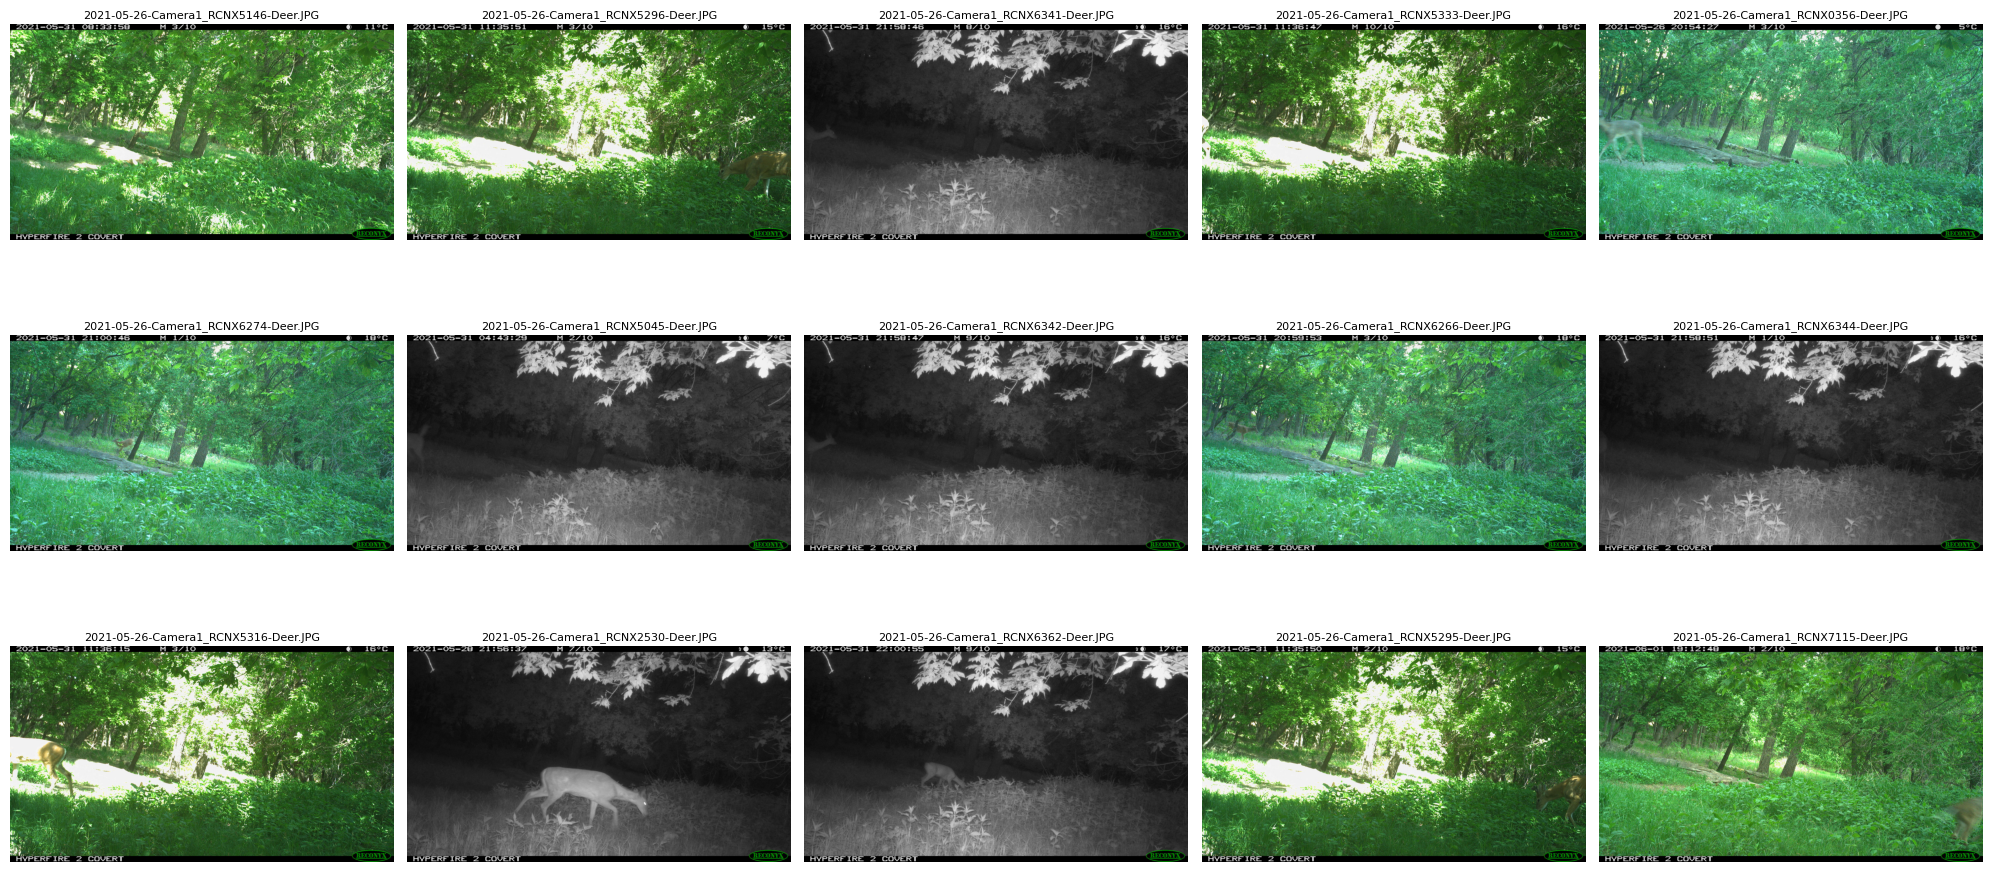

In [9]:
    # Display a subset of images
    if len(selected_files) > 0:
        selected_files_subset = random.sample(selected_files, min(images_to_display, len(selected_files)))
        fig = plt.figure(figsize=(20, 10))
        for i, file_name in enumerate(selected_files_subset):
            try:
                img = Image.open(os.path.join(destination_dir, file_name))
                ax = fig.add_subplot(3, 5, i+1)  # Assuming a grid of 3x5 images
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(file_name, fontsize=8, pad=5)
            except Exception as e:
                print(f"Error displaying image {file_name}: {e}")

        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        plt.tight_layout(pad=1)
        plt.show()
    else:
        print("No images to display!")